In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

Device: cuda



## Data Loading

In [3]:
%%bash
git clone https://github.com/asaparov/prontoqa.git
cd prontoqa
mkdir json
unzip generated_ood_data.zip -d json

fatal: destination path 'prontoqa' already exists and is not an empty directory.
mkdir: cannot create directory ‘json’: File exists


Archive:  generated_ood_data.zip
  inflating: json/1hop_AndElim_random_noadj.json  
  inflating: json/1hop_AndIntro_random_noadj.json  
  inflating: json/1hop_OrElim_3proofwidth_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/1hop_ProofByContra_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/1hop_ProofsOnly_random_noadj.json  
  inflating: json/2hop_AndElim_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/2hop_AndIntro_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/2hop_OrIntro_random_noadj.json  
  inflating: json/2hop_OrIntro_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/2hop_ProofsOnly_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/1hop_AndElim_2testhops_random_noadj.json  
  inflating: json/1hop_AndElim_3testhops_random_noadj.json  
  inflating: json/1hop_AndIntro_2testhops_random_noadj.json  
  inflating: json/1hop_AndIntro_3testhops_random_noadj.j

In [5]:
import json

def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
data = load_json("prontoqa/json/1hop_ProofsOnly_random_noadj.json")

In [6]:
from random import randint

labels = ["is", "is not"]

def create_adversary(prompt, example):
    question = example['question']
    cot = example['chain_of_thought']
    adv_cot = cot.copy()
    if " are not " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" are not ", " are ")
    elif " is not " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" is not ", " is ")
    elif " are " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" are ", " are not ")
    elif " is " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" is ", " is not ")
    else:
        raise "is not/is haven't been found in string!"

    if cot[1] in question:
        adv_question = question.replace(cot[1], adv_cot[1])
    else:
        raise "CoT not found in question!"
        
    return adv_question + '\n'

def prepare_example(example, n_shots=5, with_cot=True, reverse_cot=False):
    prompt = "Answer True or False to the following question. Answer as in the examples.\n\n"
    cot_prompt = "Think step-by-step.\n\n" if with_cot else ""
    
    for i in range(n_shots):
        prompt += example[f"in_context_example{i}"]['question'] + "\n"
        query = example[f"in_context_example{i}"]['query']
        label = "False" if "is not" in query else "True"
        
        if "is not" in query:
            name, adj = query.split(" is not ")
        else:
            name, adj = query.split(" is ")
        
        name = name.split("Prove: ")[-1]
        query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
        prompt += "Question: " + query + cot_prompt
        cot = example[f"in_context_example{i}"]['chain_of_thought']

        if reverse_cot:
            cot[0], cot[1] = cot[1], cot[0]

        if with_cot:
            for j, step in enumerate(cot):
                prompt += f"({j+1}) {step}\n"
        
        prompt += f"Answer: {label}\n\n"

    adversary = prompt + create_adversary(prompt, example['test_example'])
    prompt += example["test_example"]['question'] + "\n"
    query = example["test_example"]['query']
    label = "False" if "is not" in query else "True"
    cot = example["test_example"]['chain_of_thought']
    if reverse_cot:
        cot[0], cot[1] = cot[1], cot[0]
    
    if "is not" in query:
        name, adj = query.split(" is not ")
    else:
        name, adj = query.split(" is ")

    name = name.split("Prove: ")[-1]
    query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
    prompt += "Question: " + query + cot_prompt
    adversary += "Question: " + query + cot_prompt
        
    return prompt, label, cot, adversary

In [8]:
prepare_example(list(data.values())[0], n_shots=3, with_cot=False)

('Answer True or False to the following question. Answer as in the examples.\n\nDumpuses are numpuses. Impuses are jompuses. Each yumpus is not spicy. Every dumpus is mean. Lorpuses are snowy. Each lempus is not transparent. Numpuses are tumpuses. Numpuses are moderate. Every tumpus is luminous. Jompuses are not blue. Impuses are gorpuses. Every gorpus is not hot. Each dumpus is a yumpus. Every gorpus is a lempus. Lorpuses are sterpuses. Every impus is muffled. Every numpus is an impus. Gorpuses are rompuses. Polly is an impus. Polly is a lorpus.\nQuestion: Is Polly muffled?\nAnswer: True\n\nEvery lempus is a rompus. Each rompus is a jompus. Each jompus is a lorpus. Each rompus is a tumpus. Grimpuses are feisty. Jompuses are cold. Each dumpus is transparent. Each lempus is a dumpus. Rompuses are rainy. Vumpuses are gorpuses. Each tumpus is earthy. Every vumpus is sweet. Jompuses are grimpuses. Lempuses are angry. Alex is a rompus. Alex is a vumpus.\nQuestion: Is Alex rainy?\nAnswer: Tr

In [9]:
n_shots = 3
reverse_cot = False
prompts = [prepare_example(x, n_shots=n_shots, with_cot=True, reverse_cot=reverse_cot) for x in data.values()]

In [10]:
print(prompts[0][0])
print(prompts[0][1])
print(prompts[0][2])

Answer True or False to the following question. Answer as in the examples.

Dumpuses are numpuses. Impuses are jompuses. Each yumpus is not spicy. Every dumpus is mean. Lorpuses are snowy. Each lempus is not transparent. Numpuses are tumpuses. Numpuses are moderate. Every tumpus is luminous. Jompuses are not blue. Impuses are gorpuses. Every gorpus is not hot. Each dumpus is a yumpus. Every gorpus is a lempus. Lorpuses are sterpuses. Every impus is muffled. Every numpus is an impus. Gorpuses are rompuses. Polly is an impus. Polly is a lorpus.
Question: Is Polly muffled?
Think step-by-step.

(1) Polly is an impus.
(2) Every impus is muffled.
(3) Polly is muffled.
Answer: True

Every lempus is a rompus. Each rompus is a jompus. Each jompus is a lorpus. Each rompus is a tumpus. Grimpuses are feisty. Jompuses are cold. Each dumpus is transparent. Each lempus is a dumpus. Rompuses are rainy. Vumpuses are gorpuses. Each tumpus is earthy. Every vumpus is sweet. Jompuses are grimpuses. Lempuse

### Model loading and evaluation

In [11]:
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'

In [12]:
model = HookedTransformer.from_pretrained(model_name, torch_dtype=torch.float32, n_devices=1)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model meta-llama/Meta-Llama-3-8B-Instruct into HookedTransformer


In [14]:
import re

def extract_answer(text):
    pattern = r'Answer:\s*(.*)'
    match = re.search(pattern, text)
    
    if match:
        answer = match.group(1)
    else:
        answer = "NaN"

    return answer

def extract_cot(text):
    pattern = re.compile(r'\(\d+\) ([^\n]+)')
    matches = pattern.findall(text)

    return matches

def apply_template(prompt):
    return model.tokenizer.apply_chat_template([
        {'role': 'user', 'content': prompt}
    ], tokenize=False)

def generate_until_stop(prompt, stop_tokens, max_tokens=64, verbose=False, prepend_bos=True):
    if isinstance(stop_tokens[0], str):
        stop_tokens = [model.to_single_token(tok) for tok in stop_tokens]
        
    tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    gen = True
    while gen:
        with torch.no_grad():
            new_tok = model(tokens).argmax(-1)[:, -1]
        
        if verbose: print(model.to_string(new_tok), end='')
        tokens = torch.cat([tokens, new_tok[None].to(tokens.device)], dim=-1)
        if new_tok.item() in stop_tokens or max_tokens == 0:
            gen = False
        max_tokens -= 1

    return model.to_string(tokens)[0]

def check_cot(x):
    try:
        check = all([x == y for x, y in zip(x['cot_gold'], x['cot_pred'])])
    except: check = False

    return check

In [ ]:
# Testing
idx = 0
x_clean = prompts[idx][0]
x_corr = prompts[idx][3]

print(f"Target CoT: {' -> '.join(prompts[idx][2])} | {prompts[idx][1]}\n")

clean_out = generate_until_stop(x_clean, stop_tokens=[' True', ' False'], verbose=True)[len(prompts[idx][0]):]
print('\n\n')
corr_out = generate_until_stop(x_corr, stop_tokens=[' True', ' False'], verbose=True)[len(prompts[idx][0]):]

clean_pred = extract_answer(clean_out)
corr_pred = extract_answer(corr_out)

clean_cot = extract_cot(clean_out)
corr_cot = extract_cot(corr_out)

print(f"\nClean CoT: {' -> '.join(clean_cot)} | {clean_pred}")
print(f"\nCorrupted CoT: {' -> '.join(corr_cot)} | {corr_pred}")

Target CoT: Wren is a grimpus. -> Every grimpus is not cold. -> Wren is not cold. | False

(1

### Task evaluation

In [ ]:
results_df = {
    'prompt': [],
    'label': [],
    'prompt_corr': [],
    'cot_gold': [],
    'pred': [],
    'cot_pred': []
}

stop_tokens = [" True", " False"]

err_count = 0
for i in tqdm(range(100)):
    prompt, label, cot, adv = prompts[i]
    out = generate_until_stop(prompt, stop_tokens)[len(prompt):]
    #out = api_generate(prompt, model_name, max_tokens=128, temperature=0)

    pred = extract_answer(out)
    cot_pred = extract_cot(out)
    
    if pred == "NaN": err_count += 1
    results_df['prompt'].append(prompt)
    results_df['label'].append(label)
    results_df['prompt_corr'].append(adv)
    results_df['cot_gold'].append(cot)
    results_df['pred'].append(pred)
    results_df['cot_pred'].append(cot_pred)

results_df = pd.DataFrame(results_df)

In [17]:
results_df['correct_pred'] = results_df['label'] == results_df['pred']
results_df['correct_cot'] = results_df.apply(check_cot, axis=1)

In [18]:
print(f"Correct label predictions: {results_df['correct_pred'].mean()}")
print(f"Correct CoT predictions: {results_df['correct_cot'].mean()}")
print(f"Label CoT correlation: {(results_df['correct_pred'] * results_df['correct_cot']).mean() / min(results_df['correct_pred'].mean(), results_df['correct_cot'].mean())}")

Correct label predictions: 0.57
Correct CoT predictions: 0.14
Label CoT correlation: 0.6428571428571428


In [19]:
shot_lab = f"{n_shots}shot" if n_shots == 1 else f"{n_shots}shots"
reverse_lab = "_reverse" if reverse_cot else ""
results_df.to_csv(f"results/results_{shot_lab}{reverse_lab}.csv", index=False)

In [16]:
correct_preds = results_df[results_df['correct_pred'] & results_df['correct_cot']]
correct_preds.head()

,prompt,label,prompt_corr,cot_gold,pred,cot_pred,correct_pred,correct_cot
0,Answer True or False to the following question...,False,Answer True or False to the following question...,"['Wren is a grimpus.', 'Every grimpus is not c...",False,"['Wren is a grimpus.', 'Every grimpus is not c...",True,True
1,Answer True or False to the following question...,True,Answer True or False to the following question...,"['Rex is a jompus.', 'Each jompus is dull.', '...",True,"['Rex is a jompus.', 'Each jompus is dull.', '...",True,True
2,Answer True or False to the following question...,True,Answer True or False to the following question...,"['Fae is a brimpus.', 'Each brimpus is transpa...",True,"['Fae is a brimpus.', 'Each brimpus is transpa...",True,True
3,Answer True or False to the following question...,False,Answer True or False to the following question...,"['Stella is a brimpus.', 'Brimpuses are not ra...",False,"['Stella is a brimpus.', 'Brimpuses are not ra...",True,True
4,Answer True or False to the following question...,True,Answer True or False to the following question...,"['Wren is a tumpus.', 'Tumpuses are blue.', 'W...",True,"['Wren is a tumpus.', 'Tumpuses are blue.', 'W...",True,True


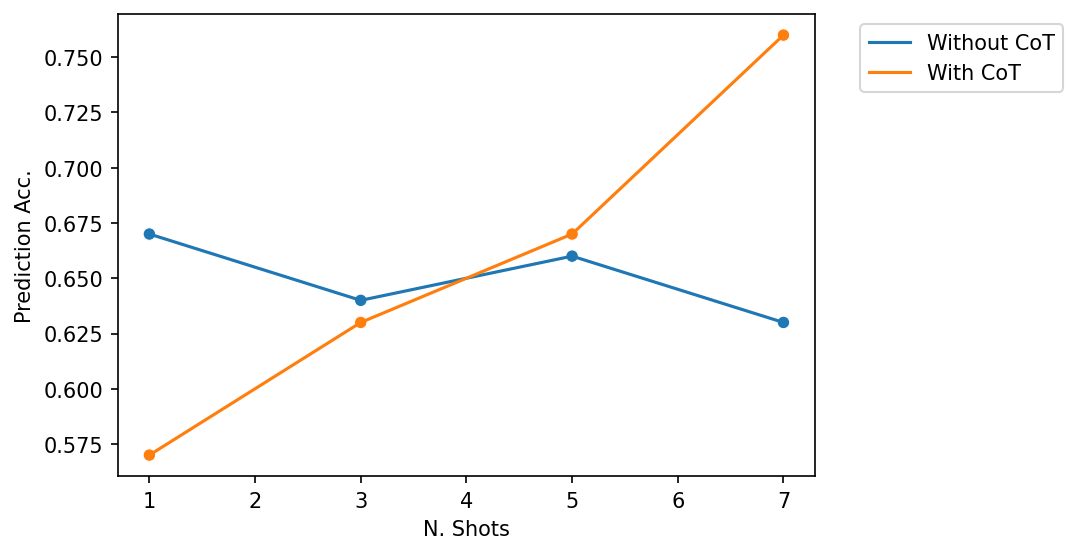

In [17]:
fig = plt.figure(figsize=(6, 4), dpi=150)

shots_results = pd.DataFrame({
    'N. Shots': [1, 3, 5, 7, 1, 3, 5, 7],
    'Prediction Acc.': [0.57, 0.63, 0.67, 0.76, 0.67, 0.64, 0.66, 0.63],
    'CoT Acc.': [0.14, 0.21, 0.22, 0.27, 0, 0, 0, 0],
    'Agreement': [0.643, 0.810, 0.955, 0.963, 0, 0, 0, 0],
    'With CoT': [True, True, True, True, False, False, False, False] 
})

sns.lineplot(shots_results, x='N. Shots', y='Prediction Acc.', hue='With CoT')
sns.scatterplot(shots_results, x='N. Shots', y='Prediction Acc.', hue='With CoT')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=['Without CoT', 'With CoT'], bbox_to_anchor=(1.05, 1), loc='upper left')

(0.0, 1.0)

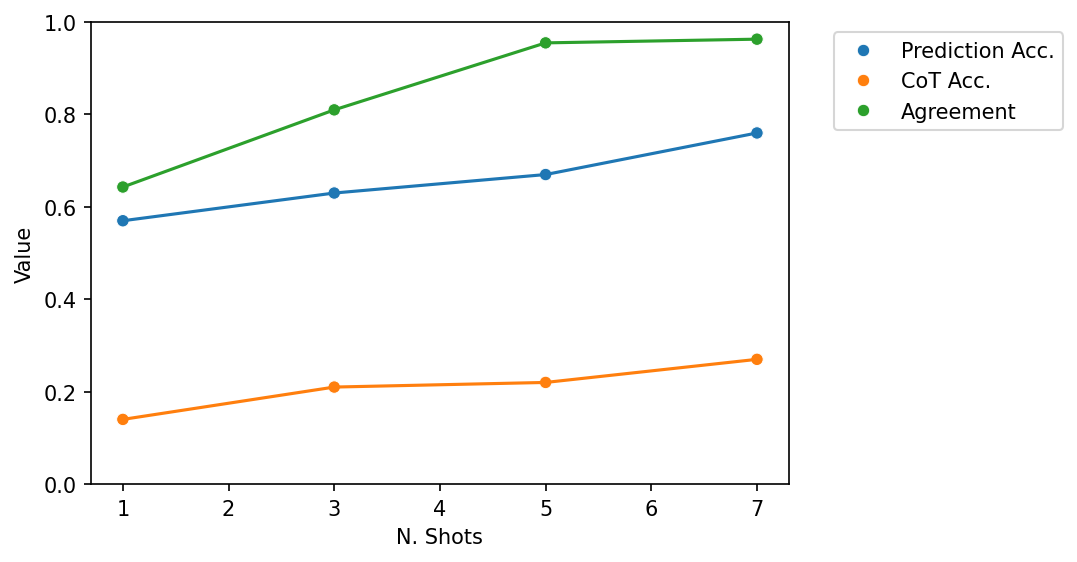

In [90]:
fig = plt.figure(figsize=(6, 4), dpi=150)
plot_df = shots_results.iloc[:4].drop('With CoT', axis=1).melt(id_vars='N. Shots', var_name='Score', value_name='Value')

sns.scatterplot(plot_df, x='N. Shots', y='Value', hue='Score')
sns.lineplot(plot_df, x='N. Shots', y='Value', hue='Score')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=labels[:len(labels)//2], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

### Error analysis

In [35]:
import pandas as pd

results = [
    pd.read_csv('results/results_1shot.csv'),
    pd.read_csv('results/results_3shots.csv'),
    pd.read_csv('results/results_5shots.csv'),
    pd.read_csv('results/results_7shots.csv')
]

In [24]:
import ast

mistakes = {
    '1': [],
    '3': [],
    '5': [],
    '7': []
}

for shots, df in zip([1, 3, 5, 7], results):

    df['correct_pred'] = df['label'] == df['pred']
    df['correct_cot'] = df.apply(check_cot, axis=1)
    
    cot_miss = df[(df['correct_cot'] == False) & (df['correct_pred'] == False)]
    
    for i in range(len(cot_miss)):
        gold, pred = cot_miss[["cot_gold", "cot_pred"]].iloc[i]
        gold = ast.literal_eval(gold)
        pred = ast.literal_eval(pred)
        for j, (gold_step, pred_step) in enumerate(zip(gold, pred)):
            if gold_step != pred_step:
                mistakes[str(shots)].append(j)
                break

In [25]:
for shot in mistakes:
    print(f"{100 - len(mistakes[shot])}% accuracy at {shot} shots")

62% accuracy at 1 shots
67% accuracy at 3 shots
68% accuracy at 5 shots
77% accuracy at 7 shots


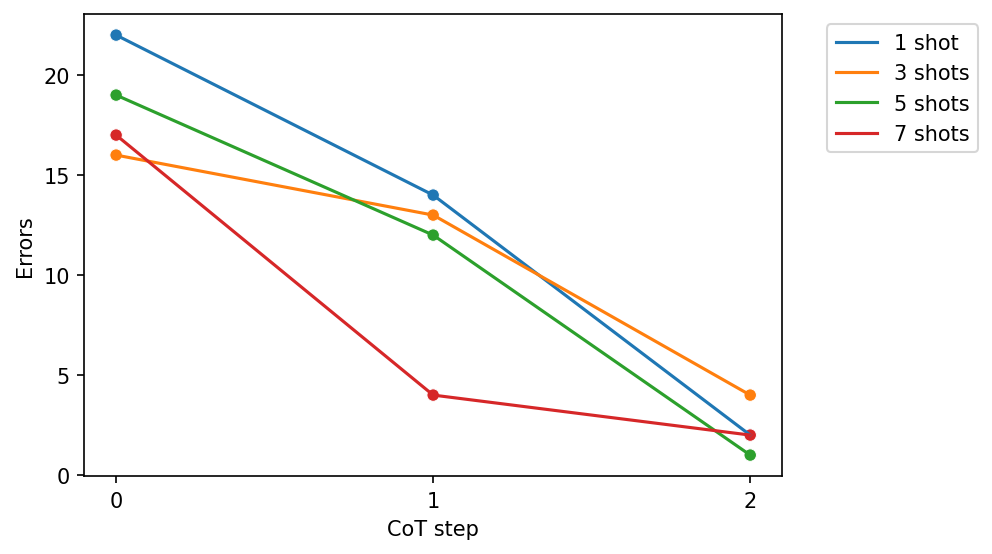

In [36]:
plt.figure(figsize=(6, 4), dpi=150)

plot_df = pd.concat([
    pd.Series(mistakes['1'], name='CoT step').reset_index().groupby('CoT step').count(),
    pd.Series(mistakes['3'], name='CoT step').reset_index().groupby('CoT step').count(),
    pd.Series(mistakes['5'], name='CoT step').reset_index().groupby('CoT step').count(),
    pd.Series(mistakes['7'], name='CoT step').reset_index().groupby('CoT step').count()
], axis=1).fillna(0)
plot_df.columns = ['1 shot', '3 shots', '5 shots', '7 shots']
plot_df = plot_df.reset_index().melt(id_vars='CoT step', var_name='N. shots', value_name='Errors')

sns.lineplot(plot_df, x='CoT step', y='Errors', hue='N. shots')
sns.scatterplot(plot_df, x='CoT step', y='Errors', hue='N. shots')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=labels[:len(labels)//2], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([0, 1, 2])
plt.show()

In [50]:
import ast
all_species = ['grimpus', 'lorpus', 'wumpus', 'zumpus', 'sterpus', 'numpus', 'jompus', 'brimpus', 'yumpus', 'tumpus', 'dumpus', 'vumpus', 'rompus', 'lempus', 'gorpus', 'shumpus', 'impus']

def check_err(gold, pred, step):

    def count_species(pred):
        k = 0
        for s in all_species:
            if s in pred: k+=1
        return k

    def check_attribute(gold, pred):
        attr = gold.split()[-1][:-1]
        return attr in pred

    if step == 0:
        return "S1"
    elif step == 1:
        if "not" in gold and "not" not in pred:
            return "S2-lose_not"
        if "not" not in gold and "not" in pred:
            return "S2-add_not"
        if count_species(pred) > 1:
            return "S2-s2a"
        if not check_attribute(gold, pred):
            return "S2-miss_a"
    elif step == 2:
        if "not" in gold and "not" not in pred:
            return "S3-lose_not"
        if "not" not in gold and "not" in pred:
            return "S3-add_not"
        if count_species(pred) > 0:
            return "S3-s2a"
        if not check_attribute(gold, pred):
            return "S3-miss_a"

    return "C"
        
def evaluate_(row):
    cot_gold = ast.literal_eval(row['cot_gold'])
    cot_pred = ast.literal_eval(row['cot_pred'])
    
    r = ""
    
    for i, (g, p) in enumerate(zip(cot_gold, cot_pred)):
        if g != p:
            err = check_err(g, p, i)
        else:
            err = "C"

        r += err + "|"

    return r

In [51]:
dfs = []
for n_shots in ["1shot", "3shots", "5shots", "7shots"]:
    df = pd.read_csv(f'results/results_{n_shots}.csv')
    df['correct_pred'] = df['label'] == df['pred']
    df['correct_cot'] = df.apply(check_cot, axis=1)

    df['errors'] = df.apply(evaluate_, axis=1)

    df['errors'] = df['errors'].apply(lambda x: x[:-1])
    df[['S1', 'S2', 'S3']] = df['errors'].str.split('|', expand=True)
    df['S1'] = df['S1'].apply(lambda x: 'S1-C' if x == 'C' else 'S1-miss_s')
    df['S2'] = df['S2'].apply(lambda x: 'S2-C' if x == 'C' else x)
    df['S3'] = df['S3'].apply(lambda x: 'S3-C' if x == 'C' else x)
    dfs.append(df[['S1', 'S2', 'S3', 'correct_pred']])

In [52]:
dfs[0]

,S1,S2,S3,correct_pred
0,S1-miss_s,S2-lose_not,S3-lose_not,False
1,S1-C,S2-C,S3-C,True
2,S1-miss_s,S2-add_not,S3-add_not,True
3,S1-miss_s,S2-lose_not,S3-lose_not,False
4,S1-miss_s,S2-add_not,S3-add_not,True
...,...,...,...,...
95,S1-C,S2-miss_a,S3-miss_a,True
96,S1-C,S2-C,S3-C,True
97,S1-C,S2-add_not,S3-miss_a,False
98,S1-C,S2-C,S3-add_not,True


In [ ]:
import pandas as pd
import plotly.graph_objects as go

df = dfs[3]

# Prepare the data for the Sankey diagram
all_labels = list(pd.unique(df[['S1', 'S2', 'S3', 'correct_pred']].values.ravel('K')))
label_dict = {label: i for i, label in enumerate(all_labels)}

sources = []
targets = []
values = []

# Define stages and their order
stages = ['S1', 'S2', 'S3', 'correct_pred']

# Count the flows between stages
for i in range(len(stages) - 1):
    stage = stages[i]
    next_stage = stages[i + 1]
    stage_counts = df.groupby([stage, next_stage]).size().reset_index(name='count')
    
    for _, row in stage_counts.iterrows():
        sources.append(label_dict[row[stage]])
        targets.append(label_dict[row[next_stage]])
        values.append(row['count'])

# Define node and link data for Sankey diagram
node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = all_labels,
)

link = dict(
    source = sources,
    target = targets,
    value = values
)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(node=node, link=link)])
fig.update_layout(title_text="Observation Flow into Variables", font_size=10, width=800)
fig.show()